# Setup

In [158]:
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

# Load experiment results
RESULTS_FILE = "rag_experiment_results.csv"
experiments = pd.read_csv(RESULTS_FILE)
# Replace NaN in reranker column with "no reranker"
experiments["cross_encoder_model"] = experiments["cross_encoder_model"].fillna("no reranker")
# --- Helper functions ---
def best_overall(df, metric="factual_correctness(mode=f1)"):
    """Return best parameters based on a target metric."""
    best_row = df.sort_values(metric, ascending=False).iloc[0]
    return best_row

def compare_groups(df, group_col, metric="factual_correctness(mode=f1)"):
    """Compare mean metric per group (e.g., index_name, reranker)."""
    return df.groupby(group_col)[metric].mean().sort_values(ascending=False)

def plot_group(df, group_col, metric="factual_correctness(mode=f1)"):
    """Quick barplot for visual comparison."""
    means = compare_groups(df, group_col, metric)
    means.plot(kind="bar", figsize=(8,4), title=f"{metric} by {group_col}")
    plt.ylabel(metric)
    plt.show()


In [159]:
experiments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 24 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   index_name                            169 non-null    object 
 1   alpha                                 169 non-null    float64
 2   similarity_top_k                      165 non-null    float64
 3   cross_encoder_model                   169 non-null    object 
 4   llm_model_name                        155 non-null    object 
 5   rerank_top_n                          169 non-null    int64  
 6   llm_provider                          155 non-null    object 
 7   prompt_template                       155 non-null    object 
 8   faithfulness                          167 non-null    float64
 9   factual_correctness(mode=f1)          167 non-null    float64
 10  llm_context_precision_with_reference  167 non-null    float64
 11  context_recall     

# Q1. Performance of Retriever?

In [160]:
experiments['index_name'].unique()

array(['Normal_splitter_hf', 'Normal_splitter_openai',
       'Normal_splitter_w_context_hf', 'Normal_splitter_w_context_openai',
       'Custom_splitter_hf', 'Custom_splitter_openai',
       'Custom_splitter_w_context_hf', 'Custom_splitter_w_context_openai'],
      dtype=object)

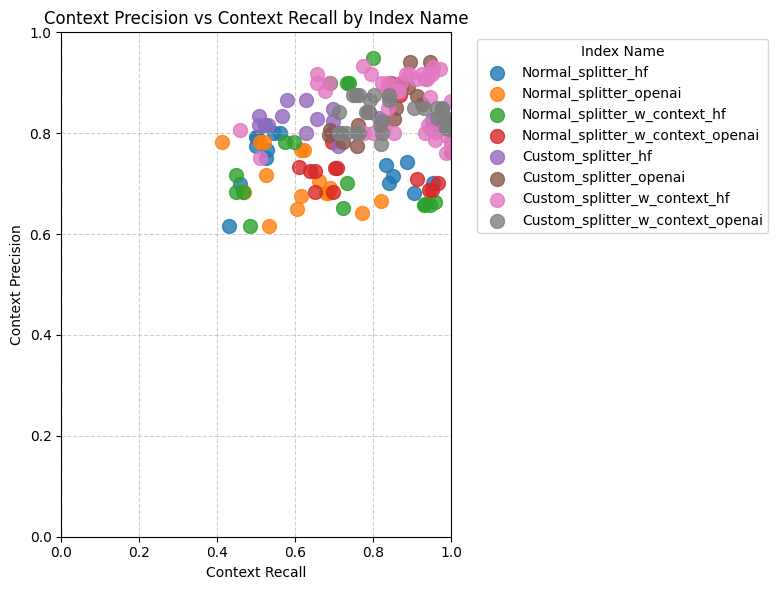

In [161]:
plt.figure(figsize=(8,6))

# Plot each index_name as a separate color
for name in experiments["index_name"].unique():
    subset = experiments[experiments["index_name"] == name]
    plt.scatter(
        subset["context_recall"], 
        subset["llm_context_precision_with_reference"], 
        label=name, 
        s=100, 
        alpha=0.8
    )

plt.title("Context Precision vs Context Recall by Index Name")
plt.xlabel("Context Recall")
plt.ylabel("Context Precision")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Index Name", bbox_to_anchor=(1.05, 1), loc="upper left")  # move legend outside
plt.tight_layout()
plt.show()


Custom Splitter, Context Augmented with hugging face embeddings is what to choose

# Q2. Performance of Generator based on chose Retriever?

In [162]:
index_condition = experiments["index_name"] == "Custom_splitter_w_context_hf"
recall_condition = experiments['context_recall'] > 0.8
precision_condition = experiments['llm_context_precision_with_reference'] > 0.8

condition = index_condition & recall_condition & precision_condition

In [163]:
experiments.columns

Index(['index_name', 'alpha', 'similarity_top_k', 'cross_encoder_model',
       'llm_model_name', 'rerank_top_n', 'llm_provider', 'prompt_template',
       'faithfulness', 'factual_correctness(mode=f1)',
       'llm_context_precision_with_reference', 'context_recall',
       'avg_latency_sec', 'latency_95th_sec', '#Experiment',
       'factual_correctness(mode=precision)',
       'factual_correctness(mode=recall)', 'fact_prompt', 'answer_prompt',
       'two_stage', 'use_query_expansion', 'query_expansion_num', 'base_k',
       'expansion_k'],
      dtype='object')

In [164]:
group_col = [
    "#Experiment"
]

experiments["#Experiment"].fillna(1)

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
164    14.0
165    15.0
166    16.0
167    17.0
168    18.0
Name: #Experiment, Length: 169, dtype: float64

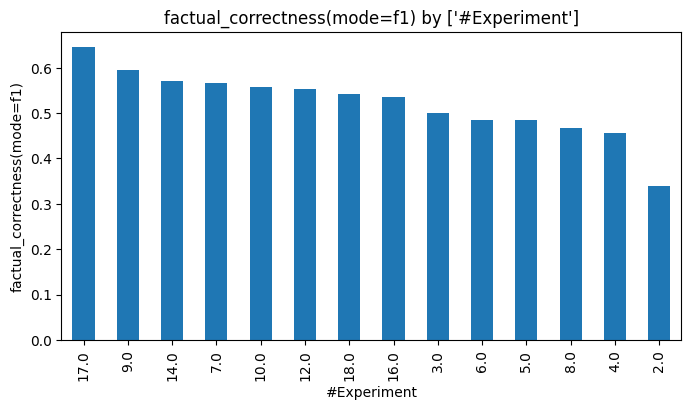

In [165]:
compare_groups(experiments[condition], group_col, metric="factual_correctness(mode=f1)")
plot_group(experiments[condition], group_col, metric="factual_correctness(mode=f1)")

In [166]:
selected_condition = experiments["#Experiment"] == 10.0

experiments[condition & selected_condition]

,index_name,alpha,similarity_top_k,cross_encoder_model,llm_model_name,rerank_top_n,llm_provider,prompt_template,faithfulness,factual_correctness(mode=f1),...,#Experiment,factual_correctness(mode=precision),factual_correctness(mode=recall),fact_prompt,answer_prompt,two_stage,use_query_expansion,query_expansion_num,base_k,expansion_k
161,Custom_splitter_w_context_hf,0.8,10.0,cross-encoder/ms-marco-MiniLM-L-2-v2,NaN,5,NaN,NaN,0.951868,0.558,...,10.0,0.483,0.813,metadata={'prompt_type': <PromptType.CUSTOM: '...,NaN,False,NaN,NaN,NaN,NaN


# Q2. What to optimize?

In [167]:
# conditions
custom_splitter_hf = experiments['index_name'] == 'Custom_splitter_w_context_hf'
context_recall_condition = experiments['context_recall'] > 0.8
context_precision_condition = experiments['llm_context_precision_with_reference'] > 0.9

experiments["#Experiment"] = experiments["#Experiment"].fillna(1)
target_df = experiments[experiments["#Experiment"] == 1]

result = target_df[custom_splitter_hf & context_recall_condition & context_precision_condition]
pprint(best_overall(result, metric="context_recall").to_dict())

{'#Experiment': 1.0,
 'alpha': 1.0,
 'answer_prompt': nan,
 'avg_latency_sec': 5.529842066764831,
 'base_k': nan,
 'context_recall': 0.9377470355731224,
 'cross_encoder_model': 'cross-encoder/ms-marco-MiniLM-L-2-v2',
 'expansion_k': nan,
 'fact_prompt': nan,
 'factual_correctness(mode=f1)': 0.4869999999999999,
 'factual_correctness(mode=precision)': nan,
 'factual_correctness(mode=recall)': nan,
 'faithfulness': 0.9652380952380952,
 'index_name': 'Custom_splitter_w_context_hf',
 'latency_95th_sec': 9.322997093200684,
 'llm_context_precision_with_reference': 0.9083333332945832,
 'llm_model_name': 'gpt-4o-mini',
 'llm_provider': 'openai',
 'prompt_template': "metadata={'prompt_type': <PromptType.CUSTOM: 'custom'>} "
                    "template_vars=['query_str', 'context_str'] kwargs={} "
                    'output_parser=None template_var_mappings=None '
                    "function_mappings=None template='You are a helpful "
                    'assistant that answers Japan visa '


/var/folders/0r/dktk9n0551j0gkccz4k6246h0000gn/T/ipykernel_3192/4129748594.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = target_df[custom_splitter_hf & context_recall_condition & context_precision_condition]


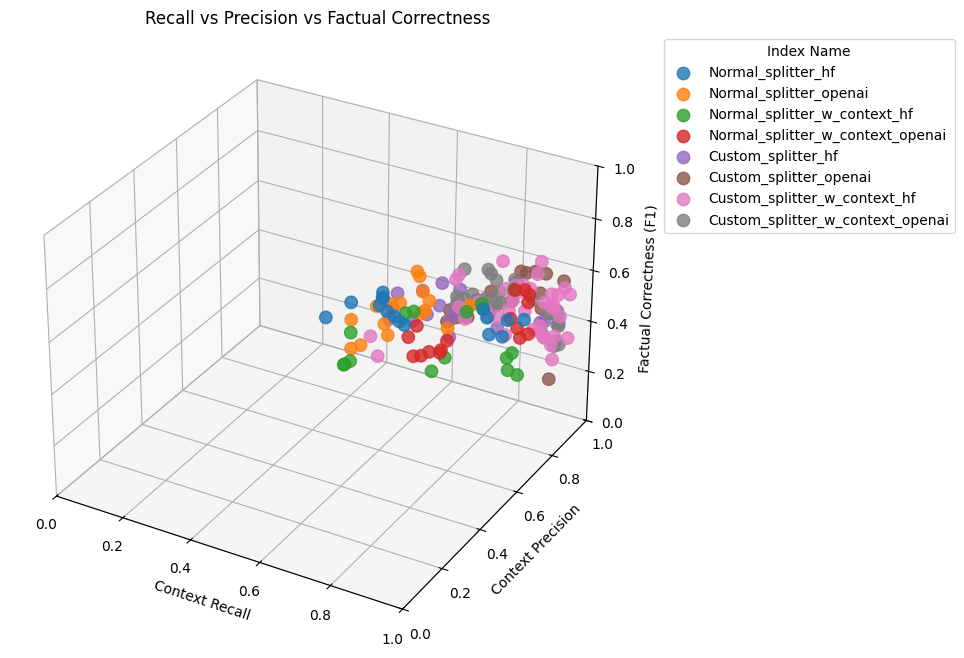

In [168]:
from mpl_toolkits.mplot3d import Axes3D

# Create figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Assign each index_name a color
index_names = experiments["index_name"].unique()
colors = plt.cm.tab10(range(len(index_names)))  # up to 10 unique colors

for i, name in enumerate(index_names):
    subset = experiments[experiments["index_name"] == name]
    ax.scatter(
        subset["context_recall"],
        subset["llm_context_precision_with_reference"],
        subset["factual_correctness(mode=f1)"],
        color=colors[i],
        s=80,
        alpha=0.8,
        label=name
    )

# Axis labels
ax.set_xlabel("Context Recall")
ax.set_ylabel("Context Precision")
ax.set_zlabel("Factual Correctness (F1)")

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

plt.title("Recall vs Precision vs Factual Correctness")
ax.legend(title="Index Name", bbox_to_anchor=(1.05, 1), loc='upper left')  # legend outside

plt.show()


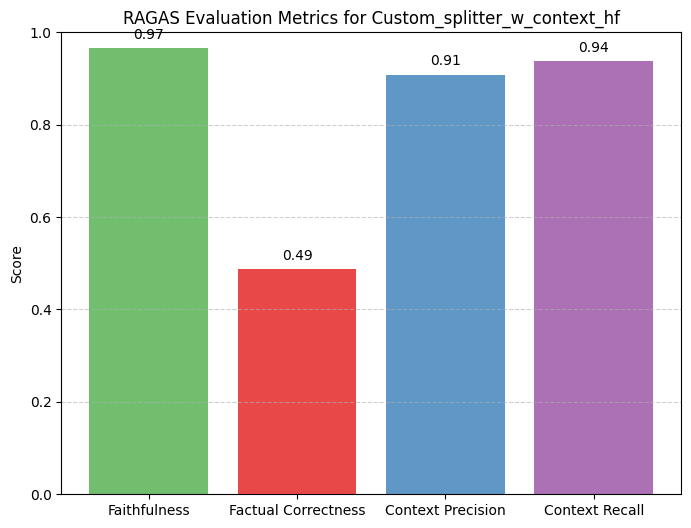

In [169]:
result_params = best_overall(result).to_dict()

# Your metrics dictionary
metrics = {
    "Faithfulness": result_params['faithfulness'],
    "Factual Correctness": result_params['factual_correctness(mode=f1)'],
    "Context Precision": result_params['llm_context_precision_with_reference'],
    "Context Recall": result_params['context_recall']
}

# Bar plot
plt.figure(figsize=(8,6))
plt.bar(metrics.keys(), metrics.values(), color=["#4daf4a", "#e41a1c", "#377eb8", "#984ea3"], alpha=0.8)

plt.title("RAGAS Evaluation Metrics for Custom_splitter_w_context_hf")
plt.ylabel("Score")
plt.ylim(0, 1)  # since all metrics are proportions
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Annotate values on top of bars
for i, (metric, value) in enumerate(metrics.items()):
    plt.text(i, value + 0.02, f"{value:.2f}", ha="center", fontsize=10)

plt.show()


after change the prompt

In [170]:
experiments.columns

Index(['index_name', 'alpha', 'similarity_top_k', 'cross_encoder_model',
       'llm_model_name', 'rerank_top_n', 'llm_provider', 'prompt_template',
       'faithfulness', 'factual_correctness(mode=f1)',
       'llm_context_precision_with_reference', 'context_recall',
       'avg_latency_sec', 'latency_95th_sec', '#Experiment',
       'factual_correctness(mode=precision)',
       'factual_correctness(mode=recall)', 'fact_prompt', 'answer_prompt',
       'two_stage', 'use_query_expansion', 'query_expansion_num', 'base_k',
       'expansion_k'],
      dtype='object')

In [171]:
after_change = experiments[experiments["#Experiment"] == 17]
after_change.to_dict()

{'index_name': {167: 'Custom_splitter_w_context_hf'},
 'alpha': {167: 0.8},
 'similarity_top_k': {167: nan},
 'cross_encoder_model': {167: 'cross-encoder/ms-marco-MiniLM-L-6-v2'},
 'llm_model_name': {167: nan},
 'rerank_top_n': {167: 5},
 'llm_provider': {167: nan},
 'prompt_template': {167: nan},
 'faithfulness': {167: 0.968352994555354},
 'factual_correctness(mode=f1)': {167: 0.647},
 'llm_context_precision_with_reference': {167: 0.9183333333123472},
 'context_recall': {167: 0.8928571428571429},
 'avg_latency_sec': {167: 31.18051264286041},
 'latency_95th_sec': {167: 37.07489800453186},
 '#Experiment': {167: 17.0},
 'factual_correctness(mode=precision)': {167: 0.627},
 'factual_correctness(mode=recall)': {167: 0.808},
 'fact_prompt': {167: 'metadata={\'prompt_type\': <PromptType.CUSTOM: \'custom\'>} template_vars=[\'query_str\', \'context_str\'] kwargs={} output_parser=None template_var_mappings=None function_mappings=None template="You are a Japan visa assistant.\\n\\nYour task is t

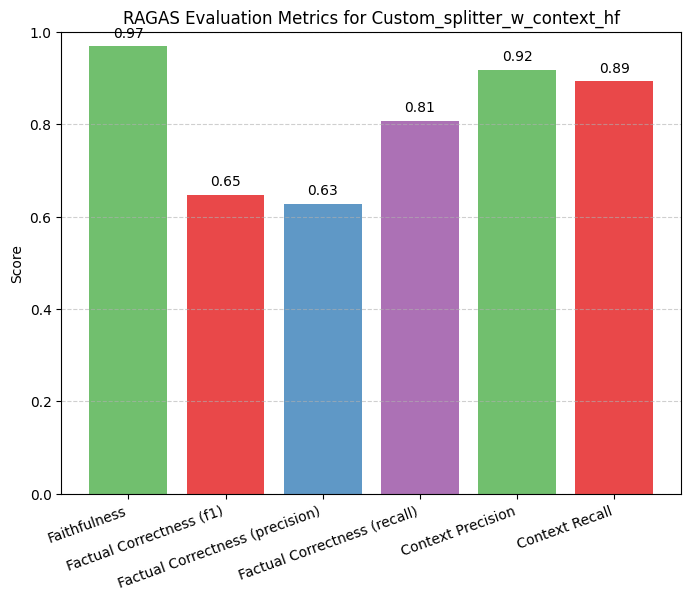

In [172]:
result_params = best_overall(after_change).to_dict()

# Your metrics dictionary
metrics = {
    "Faithfulness": result_params['faithfulness'],
    "Factual Correctness (f1)": result_params['factual_correctness(mode=f1)'],
    "Factual Correctness (precision)": result_params['factual_correctness(mode=precision)'],
    "Factual Correctness (recall)": result_params['factual_correctness(mode=recall)'],
    "Context Precision": result_params['llm_context_precision_with_reference'],
    "Context Recall": result_params['context_recall']
}

# Bar plot
plt.figure(figsize=(8,6))
plt.bar(metrics.keys(), metrics.values(), color=["#4daf4a", "#e41a1c", "#377eb8", "#984ea3"], alpha=0.8)

plt.title("RAGAS Evaluation Metrics for Custom_splitter_w_context_hf")
plt.ylabel("Score")
plt.ylim(0, 1)  # since all metrics are proportions
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.xticks(rotation=20, ha="right")

# Annotate values on top of bars
for i, (metric, value) in enumerate(metrics.items()):
    plt.text(i, value + 0.02, f"{value:.2f}", ha="center", fontsize=10)

plt.show()

In [173]:
after_change = df[df["#Experiment"] == 4]

NameError: name 'df' is not defined

In [ ]:
df.columns

Index(['index_name', 'alpha', 'similarity_top_k', 'cross_encoder_model',
       'llm_model_name', 'rerank_top_n', 'llm_provider', 'prompt_template',
       'faithfulness', 'factual_correctness(mode=f1)',
       'llm_context_precision_with_reference', 'context_recall',
       'avg_latency_sec', 'latency_95th_sec', '#Experiment',
       'factual_correctness(mode=precision)',
       'factual_correctness(mode=recall)', 'fact_prompt', 'answer_prompt'],
      dtype='object')

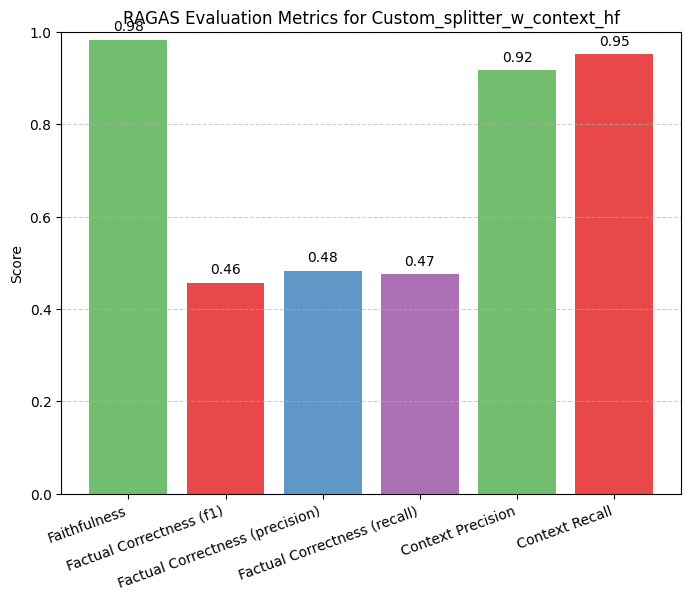

In [ ]:

result_params = best_overall(after_change).to_dict()

# Your metrics dictionary
metrics = {
    "Faithfulness": result_params['faithfulness'],
    "Factual Correctness (f1)": result_params['factual_correctness(mode=f1)'],
    "Factual Correctness (precision)": result_params['factual_correctness(mode=precision)'],
    "Factual Correctness (recall)": result_params['factual_correctness(mode=recall)'],
    "Context Precision": result_params['llm_context_precision_with_reference'],
    "Context Recall": result_params['context_recall']
}

# Bar plot
plt.figure(figsize=(8,6))
plt.bar(metrics.keys(), metrics.values(), color=["#4daf4a", "#e41a1c", "#377eb8", "#984ea3"], alpha=0.8)

plt.title("RAGAS Evaluation Metrics for Custom_splitter_w_context_hf")
plt.ylabel("Score")
plt.ylim(0, 1)  # since all metrics are proportions
plt.grid(axis="y", linestyle="--", alpha=0.6)
# Rotate x-axis labels
plt.xticks(rotation=20, ha="right")

# Annotate values on top of bars
for i, (metric, value) in enumerate(metrics.items()):
    plt.text(i, value + 0.02, f"{value:.2f}", ha="center", fontsize=10)

plt.show()

In [ ]:
after_change = df[df["#Experiment"] == 5]
after_change

,index_name,alpha,similarity_top_k,cross_encoder_model,llm_model_name,rerank_top_n,llm_provider,prompt_template,faithfulness,factual_correctness(mode=f1),llm_context_precision_with_reference,context_recall,avg_latency_sec,latency_95th_sec,#Experiment,factual_correctness(mode=precision),factual_correctness(mode=recall),fact_prompt,answer_prompt
151,Custom_splitter_w_context_hf,1.0,3,cross-encoder/ms-marco-MiniLM-L-2-v2,gpt-4o-mini,3,openai,metadata={'prompt_type': <PromptType.CUSTOM: '...,1.0,0.485,0.916667,0.924374,5.026739,8.484055,5.0,0.496,0.477,NaN,NaN


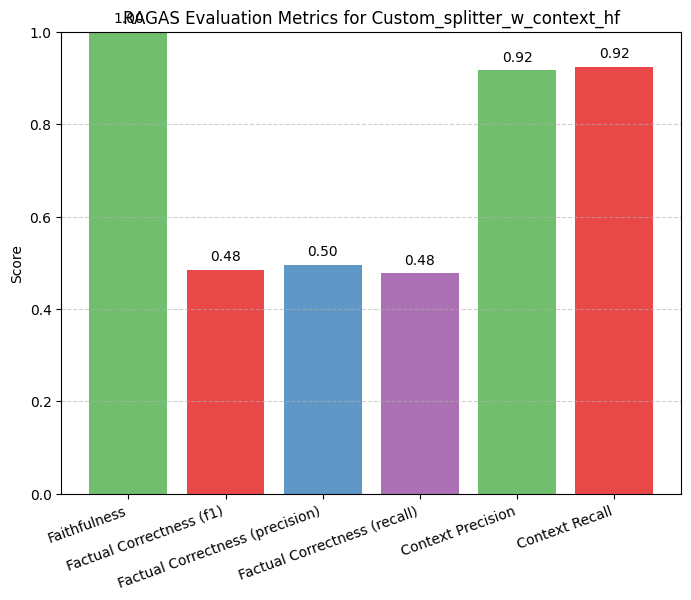

In [ ]:

result_params = best_overall(after_change).to_dict()

# Your metrics dictionary
metrics = {
    "Faithfulness": result_params['faithfulness'],
    "Factual Correctness (f1)": result_params['factual_correctness(mode=f1)'],
    "Factual Correctness (precision)": result_params['factual_correctness(mode=precision)'],
    "Factual Correctness (recall)": result_params['factual_correctness(mode=recall)'],
    "Context Precision": result_params['llm_context_precision_with_reference'],
    "Context Recall": result_params['context_recall']
}

# Bar plot
plt.figure(figsize=(8,6))
plt.bar(metrics.keys(), metrics.values(), color=["#4daf4a", "#e41a1c", "#377eb8", "#984ea3"], alpha=0.8)

plt.title("RAGAS Evaluation Metrics for Custom_splitter_w_context_hf")
plt.ylabel("Score")
plt.ylim(0, 1)  # since all metrics are proportions
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Rotate x-axis labels
plt.xticks(rotation=20, ha="right")

# Annotate values on top of bars
for i, (metric, value) in enumerate(metrics.items()):
    plt.text(i, value + 0.02, f"{value:.2f}", ha="center", fontsize=10)

plt.show()

In [ ]:
after_change.to_dict()

{'index_name': {151: 'Custom_splitter_w_context_hf'},
 'alpha': {151: 1.0},
 'similarity_top_k': {151: 3},
 'cross_encoder_model': {151: 'cross-encoder/ms-marco-MiniLM-L-2-v2'},
 'llm_model_name': {151: 'gpt-4o-mini'},
 'rerank_top_n': {151: 3},
 'llm_provider': {151: 'openai'},
 'prompt_template': {151: "metadata={'prompt_type': <PromptType.CUSTOM: 'custom'>} template_vars=['query_str', 'context_str'] kwargs={} output_parser=None template_var_mappings=None function_mappings=None template='You are a helpful assistant that answers Japan visa questions.\\n\\nYou must follow these rules:\\n1. Use ONLY the information in the retrieved documents below.\\n2. Do NOT add any information that is not explicitly supported by the documents.\\n3. Provide a complete answer, but concise. Cover all relevant details from the documents without adding extra assumptions.\\n\\nQuestion: {query_str}\\n\\nRetrieved documents:\\n{context_str}\\n\\nAnswer:'"},
 'faithfulness': {151: 1.0},
 'factual_correctness

In [ ]:
after_change = df[df["#Experiment"] == 6]
after_change = after_change.iloc[0]
after_change

index_name                                                   Custom_splitter_w_context_hf
alpha                                                                                 1.0
similarity_top_k                                                                        3
cross_encoder_model                                  cross-encoder/ms-marco-MiniLM-L-2-v2
llm_model_name                                                                      gpt-5
rerank_top_n                                                                            3
llm_provider                                                                       openai
prompt_template                         metadata={'prompt_type': <PromptType.CUSTOM: '...
faithfulness                                                                     0.970392
factual_correctness(mode=f1)                                                        0.546
llm_context_precision_with_reference                                                  0.9
context_re

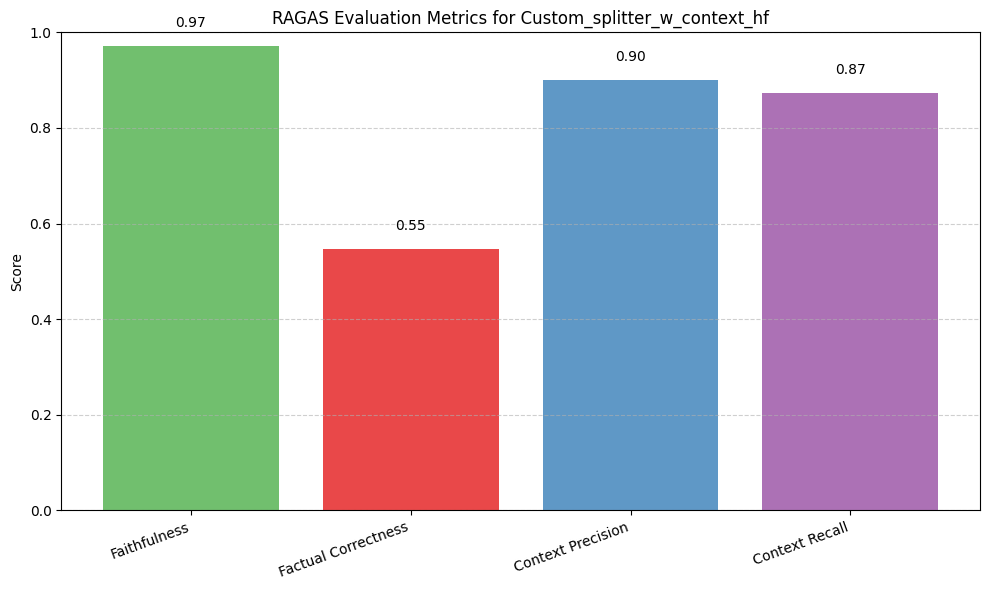

In [ ]:
result_params = after_change.to_dict()

# Your metrics dictionary
metrics = {
    "Faithfulness": result_params['faithfulness'],
    "Factual Correctness": result_params['factual_correctness(mode=f1)'],
    "Context Precision": result_params['llm_context_precision_with_reference'],
    "Context Recall": result_params['context_recall']
}

plt.figure(figsize=(10,6))
plt.bar(metrics.keys(), metrics.values(),
        color=["#4daf4a", "#e41a1c", "#377eb8", "#984ea3", "#ff7f00", "#a65628"],
        alpha=0.8)

plt.title("RAGAS Evaluation Metrics for Custom_splitter_w_context_hf")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Rotate x-axis labels
plt.xticks(rotation=20, ha="right")

# Annotate with dynamic spacing
for i, (metric, value) in enumerate(metrics.items()):
    plt.text(i, value + 0.04, f"{value:.2f}", ha="center", fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
after_change.to_dict()

{'index_name': 'Custom_splitter_w_context_hf',
 'alpha': 1.0,
 'similarity_top_k': 3,
 'cross_encoder_model': 'cross-encoder/ms-marco-MiniLM-L-2-v2',
 'llm_model_name': 'gpt-5',
 'rerank_top_n': 3,
 'llm_provider': 'openai',
 'prompt_template': "metadata={'prompt_type': <PromptType.CUSTOM: 'custom'>} template_vars=['query_str', 'context_str'] kwargs={} output_parser=None template_var_mappings=None function_mappings=None template='You are a helpful assistant that answers Japan visa questions.\\n\\nYou must follow these rules:\\n1. Use ONLY the information in the retrieved documents below.\\n2. Do NOT add any information that is not explicitly supported by the documents.\\n3. Provide a complete answer, but concise. Cover all relevant details from the documents without adding extra assumptions.\\n\\nQuestion: {query_str}\\n\\nRetrieved documents:\\n{context_str}\\n\\nAnswer:'",
 'faithfulness': 0.9703921568627452,
 'factual_correctness(mode=f1)': 0.546,
 'llm_context_precision_with_refere

# Q3. Reranker or not?

In [ ]:
result

,index_name,alpha,similarity_top_k,cross_encoder_model,llm_model_name,rerank_top_n,llm_provider,prompt_template,faithfulness,factual_correctness(mode=f1),llm_context_precision_with_reference,context_recall,avg_latency_sec,latency_95th_sec,#Experiment,factual_correctness(mode=precision),factual_correctness(mode=recall),fact_prompt,answer_prompt
105,Custom_splitter_w_context_hf,1.0,3,cross-encoder/ms-marco-MiniLM-L-2-v2,gpt-4o-mini,3,openai,metadata={'prompt_type': <PromptType.CUSTOM: '...,0.965238,0.487,0.908333,0.937747,5.529842,9.322997,1.0,NaN,NaN,NaN,NaN


In [ ]:
df.columns

Index(['index_name', 'alpha', 'similarity_top_k', 'cross_encoder_model',
       'llm_model_name', 'rerank_top_n', 'llm_provider', 'prompt_template',
       'faithfulness', 'factual_correctness(mode=f1)',
       'llm_context_precision_with_reference', 'context_recall',
       'avg_latency_sec', 'latency_95th_sec', '#Experiment',
       'factual_correctness(mode=precision)',
       'factual_correctness(mode=recall)', 'fact_prompt', 'answer_prompt'],
      dtype='object')

In [ ]:
target_df = df[df["index_name"] == "Custom_splitter_w_context_hf"]

In [ ]:
group_col = [
    "alpha",
    "cross_encoder_model",
    "similarity_top_k",
    "rerank_top_n"
]

In [ ]:
compare_groups(target_df, group_col, metric="context_recall")

alpha  cross_encoder_model                   similarity_top_k  rerank_top_n
0.8    no reranker                           15                3               1.000000
       cross-encoder/ms-marco-MiniLM-L-2-v2  15                5               1.000000
1.0    no reranker                           15                3               0.993400
                                             10                3               0.974335
0.8    no reranker                           10                3               0.960865
1.0    no reranker                           3                 3               0.940404
0.8    no reranker                           5                 3               0.933182
1.0    cross-encoder/ms-marco-MiniLM-L-2-v2  3                 3               0.921205
       no reranker                           5                 3               0.853922
0.8    cross-encoder/ms-marco-MiniLM-L-2-v2  10                3               0.850292
1.0    cross-encoder/ms-marco-MiniLM-L-2-v2 

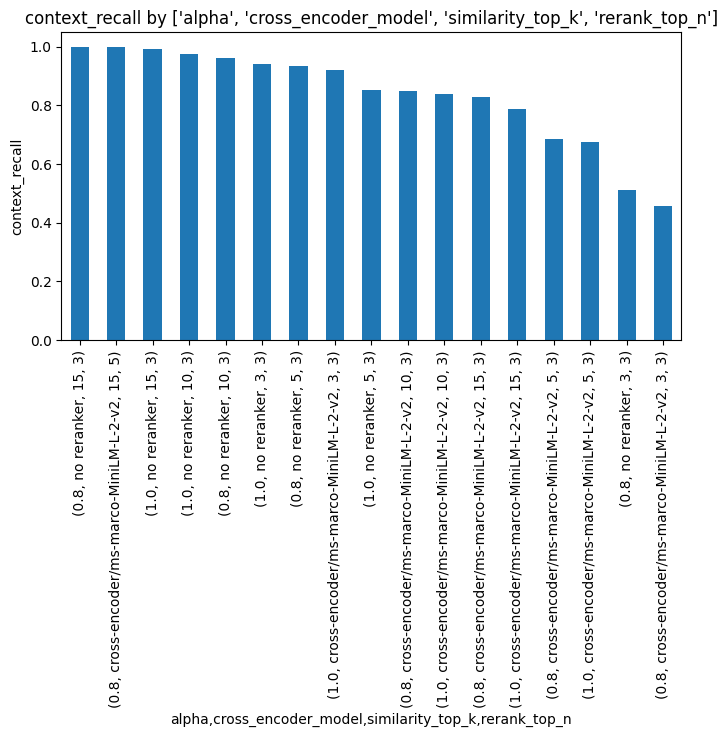

In [ ]:
plot_group(target_df, group_col, metric="context_recall")

In [ ]:
after_change = df[df["#Experiment"] == 6]
after_change = after_change.iloc[1]
after_change.to_dict()

{'index_name': 'Custom_splitter_w_context_hf',
 'alpha': 0.8,
 'similarity_top_k': 15,
 'cross_encoder_model': 'cross-encoder/ms-marco-MiniLM-L-2-v2',
 'llm_model_name': 'gpt-5',
 'rerank_top_n': 5,
 'llm_provider': 'openai',
 'prompt_template': "metadata={'prompt_type': <PromptType.CUSTOM: 'custom'>} template_vars=['query_str', 'context_str'] kwargs={} output_parser=None template_var_mappings=None function_mappings=None template='You are a helpful assistant that answers Japan visa questions.\\n\\nYou must follow these rules:\\n1. Use ONLY the information in the retrieved documents below.\\n2. Do NOT add any information that is not explicitly supported by the documents.\\n3. Provide a complete answer, but concise. Cover all relevant details from the documents without adding extra assumptions.\\n\\nQuestion: {query_str}\\n\\nRetrieved documents:\\n{context_str}\\n\\nAnswer:'",
 'faithfulness': 0.9607142857142856,
 'factual_correctness(mode=f1)': 0.425,
 'llm_context_precision_with_refer

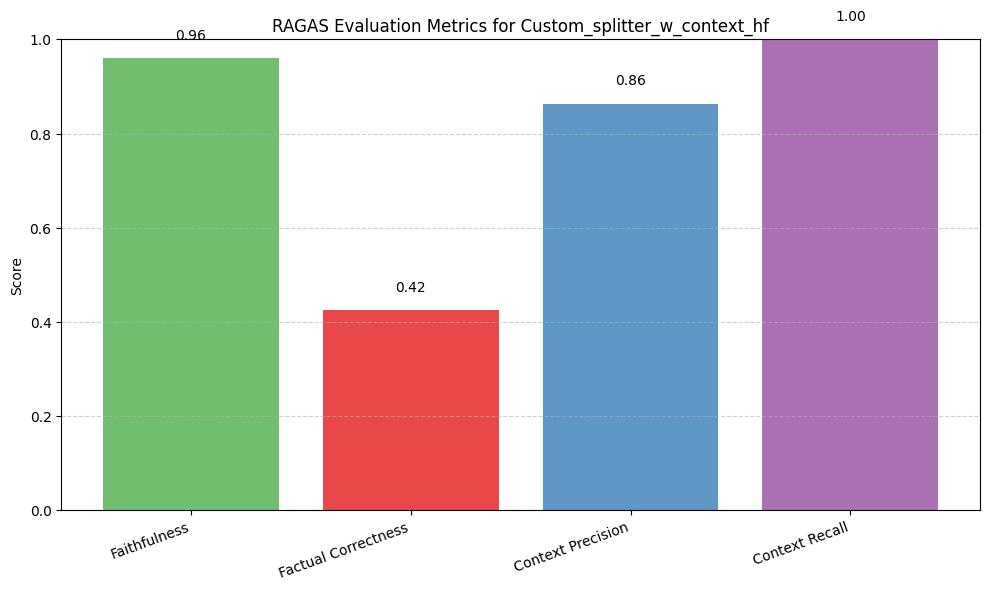

In [ ]:
result_params = after_change.to_dict()

# Your metrics dictionary
metrics = {
    "Faithfulness": result_params['faithfulness'],
    "Factual Correctness": result_params['factual_correctness(mode=f1)'],
    "Context Precision": result_params['llm_context_precision_with_reference'],
    "Context Recall": result_params['context_recall']
}
plt.figure(figsize=(10,6))
plt.bar(metrics.keys(), metrics.values(),
        color=["#4daf4a", "#e41a1c", "#377eb8", "#984ea3", "#ff7f00", "#a65628"],
        alpha=0.8)

plt.title("RAGAS Evaluation Metrics for Custom_splitter_w_context_hf")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Rotate x-axis labels
plt.xticks(rotation=20, ha="right")

# Annotate with dynamic spacing
for i, (metric, value) in enumerate(metrics.items()):
    plt.text(i, value + 0.04, f"{value:.2f}", ha="center", fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
after_change = df[df["#Experiment"] == 8]
after_change = after_change.iloc[0]
after_change

index_name                                                   Custom_splitter_w_context_hf
alpha                                                                                 0.8
similarity_top_k                                                                       10
cross_encoder_model                                  cross-encoder/ms-marco-MiniLM-L-2-v2
llm_model_name                                                                        NaN
rerank_top_n                                                                            3
llm_provider                                                                          NaN
prompt_template                                                                       NaN
faithfulness                                                                     0.904148
factual_correctness(mode=f1)                                                        0.467
llm_context_precision_with_reference                                             0.883333
context_re

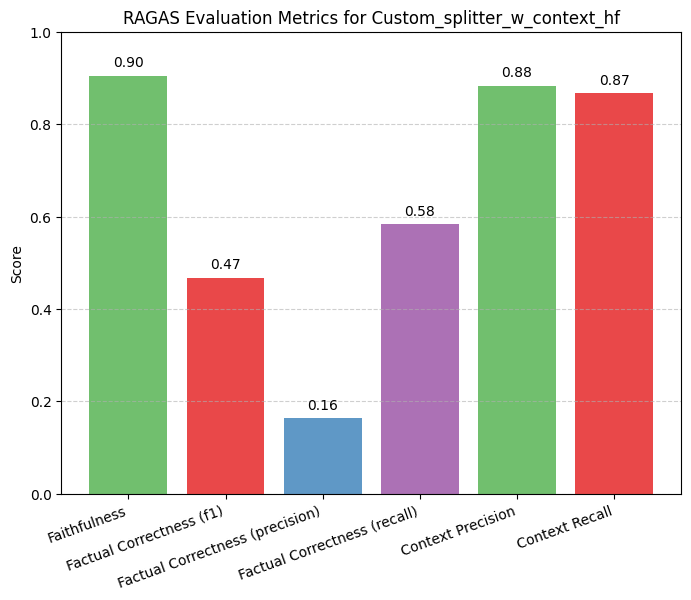

In [ ]:
result_params = after_change.to_dict()

# Your metrics dictionary
metrics = {
    "Faithfulness": result_params['faithfulness'],
    "Factual Correctness (f1)": result_params['factual_correctness(mode=f1)'],
    "Factual Correctness (precision)": result_params['factual_correctness(mode=precision)'],
    "Factual Correctness (recall)": result_params['factual_correctness(mode=recall)'],
    "Context Precision": result_params['llm_context_precision_with_reference'],
    "Context Recall": result_params['context_recall']
}

# Bar plot
plt.figure(figsize=(8,6))
plt.bar(metrics.keys(), metrics.values(), color=["#4daf4a", "#e41a1c", "#377eb8", "#984ea3"], alpha=0.8)

plt.title("RAGAS Evaluation Metrics for Custom_splitter_w_context_hf")
plt.ylabel("Score")
plt.ylim(0, 1)  # since all metrics are proportions
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Rotate x-axis labels
plt.xticks(rotation=20, ha="right")

# Annotate values on top of bars
for i, (metric, value) in enumerate(metrics.items()):
    plt.text(i, value + 0.02, f"{value:.2f}", ha="center", fontsize=10)

plt.show()